# Import Libraries and Data

In [1]:
import os
import glob
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as sm

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

import xgboost as xgb

import tensorflow as tf
from tensorflow.keras import Sequential, optimizers, losses, layers

from dmba import regressionSummary, exhaustive_search
from dmba import backward_elimination, forward_selection, stepwise_selection
from dmba import adjusted_r2_score, AIC_score, BIC_score

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

Data Courtesy of https://ieee-dataport.org/open-access/battery-and-heating-data-real-driving-cycles

In [2]:
# Import Trip Data Set
for dirname, _, filenames in os.walk('archive/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        print(filename.replace('.csv', ''))

archive/Overview.xlsx
Overview.xlsx
archive/readin.m
readin.m
archive/TripA01.csv
TripA01
archive/TripA02.csv
TripA02
archive/TripA03.csv
TripA03
archive/TripA04.csv
TripA04
archive/TripA05.csv
TripA05
archive/TripA06.csv
TripA06
archive/TripA07.csv
TripA07
archive/TripA08.csv
TripA08
archive/TripA09.csv
TripA09
archive/TripA10.csv
TripA10
archive/TripA11.csv
TripA11
archive/TripA12.csv
TripA12
archive/TripA13.csv
TripA13
archive/TripA14.csv
TripA14
archive/TripA15.csv
TripA15
archive/TripA16.csv
TripA16
archive/TripA17.csv
TripA17
archive/TripA18.csv
TripA18
archive/TripA19.csv
TripA19
archive/TripA20.csv
TripA20
archive/TripA21.csv
TripA21
archive/TripA22.csv
TripA22
archive/TripA23.csv
TripA23
archive/TripA24.csv
TripA24
archive/TripA25.csv
TripA25
archive/TripA26.csv
TripA26
archive/TripA27.csv
TripA27
archive/TripA28.csv
TripA28
archive/TripA29.csv
TripA29
archive/TripA30.csv
TripA30
archive/TripA31.csv
TripA31
archive/TripA32.csv
TripA32
archive/TripB01.csv
TripB01
archive/TripB0

In [3]:
overview = pd.read_excel("archive/Overview.xlsx")

In [4]:
overview.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 16 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Trip                              70 non-null     object 
 1   Date                              70 non-null     object 
 2   Route/Area                        70 non-null     object 
 3   Weather                           70 non-null     object 
 4   Battery Temperature (Start) [°C]  70 non-null     float64
 5   Battery Temperature (End)         70 non-null     float64
 6   Battery State of Charge (Start)   70 non-null     float64
 7   Battery State of Charge (End)     70 non-null     float64
 8   Unnamed: 8                        70 non-null     float64
 9   Ambient Temperature (Start) [°C]  70 non-null     float64
 10  Target Cabin Temperature          70 non-null     float64
 11  Distance [km]                     70 non-null     float64
 12  Duration [

In [5]:
# Column 8 refers to the change in battery from start to finish. We will rename to Delta Battery
overview.rename(columns={"Unnamed: 8": "Delta Battery"}, inplace=True)

# Column 13 is a empty column so we will delete it
# overview = overview.drop(columns=['Unnamed: 13'])

overview.Date

0     2019-06-25_13-21-14
1     2019-06-25_14-05-31
2     2019-06-28_10-02-15
3     2019-06-28_10-13-30
4     2019-06-28_10-20-26
             ...         
67    2020-01-14_12-55-08
68    2020-01-14_17-59-06
69    2020-01-15_10-43-44
70    2020-01-21_09-15-20
71    2020-02-07_09-32-02
Name: Date, Length: 72, dtype: object

In [6]:
def combine_csv():
    df_main = pd.DataFrame()
    for filename in glob.glob('archive/'+'*.csv'):
        df_trip = pd.read_csv(filename, sep=';', encoding="unicode_escape")
        
        if 'Velocity [km/h]]]' in df_trip.columns:
            df_trip.rename(columns={"Velocity [km/h]]]": "Velocity [km/h]"}, inplace=True)

        match = re.search(r'(Trip[A-Z]\d+).csv', filename)
        if match:
            trip = match.group(1)

        df_trip['Trip'] = trip
            
        df_main = pd.concat([df_main, df_trip])

    df_main.to_csv('All_Trips.csv', index=False)
    return df_main.head(3)

# combine_csv()

# Exploratory Data Analysis

In [75]:
all_trips = pd.read_csv("All_Trips.csv")

In [76]:
all_trips.columns

Index(['Time [s]', 'Velocity [km/h]', 'Elevation [m]', 'Throttle [%]',
       'Motor Torque [Nm]', 'Longitudinal Acceleration [m/s^2]',
       'Regenerative Braking Signal ', 'Battery Voltage [V]',
       'Battery Current [A]', 'Battery Temperature [°C]',
       'max. Battery Temperature [°C]', 'SoC [%]', 'displayed SoC [%]',
       'min. SoC [%]', 'max. SoC [%)', 'Heating Power CAN [kW]',
       'Heating Power LIN [W]', 'Requested Heating Power [W]',
       'AirCon Power [kW]', 'Heater Signal', 'Heater Voltage [V]',
       'Heater Current [A]', 'Ambient Temperature [°C]',
       'Coolant Temperature Heatercore [°C]',
       'Requested Coolant Temperature [°C]', 'Coolant Temperature Inlet [°C]',
       'Heat Exchanger Temperature [°C]', 'Cabin Temperature Sensor [°C]',
       'Trip', 'Unnamed: 23', 'Ambient Temperature Sensor [°C]',
       'Coolant Volume Flow +500 [l/h]',
       'Temperature Coolant Heater Inlet [°C]',
       'Temperature Coolant Heater Outlet [°C]',
       'Temperatu

In [77]:
all_trips.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1094793 entries, 0 to 1094792
Data columns (total 50 columns):
 #   Column                                  Non-Null Count    Dtype  
---  ------                                  --------------    -----  
 0   Time [s]                                1094793 non-null  float64
 1   Velocity [km/h]                         1094793 non-null  float64
 2   Elevation [m]                           1094793 non-null  float64
 3   Throttle [%]                            1094793 non-null  float64
 4   Motor Torque [Nm]                       1094793 non-null  float64
 5   Longitudinal Acceleration [m/s^2]       1094793 non-null  float64
 6   Regenerative Braking Signal             1094793 non-null  float64
 7   Battery Voltage [V]                     1094793 non-null  float64
 8   Battery Current [A]                     1094793 non-null  float64
 9   Battery Temperature [°C]                1094793 non-null  float64
 10  max. Battery Temperature [°C] 

In [78]:
all_trips = all_trips.drop(columns=['displayed SoC [%]', 'Coolant Temperature Heatercore [°C]',
       'Requested Coolant Temperature [°C]', 'Coolant Temperature Inlet [°C]',
       'Heat Exchanger Temperature [°C]', 'Cabin Temperature Sensor [°C]',
       'Unnamed: 23', 'Ambient Temperature Sensor [°C]',
       'min. SoC [%]', 'max. SoC [%)', 'Coolant Volume Flow +500 [l/h]',
       'Requested Heating Power [W]', 'Temperature Coolant Heater Inlet [°C]',
       'Heater Voltage [V]', 'Heater Current [A]', 'Temperature Coolant Heater Outlet [°C]',
       'Temperature Heat Exchanger Outlet [°C]', 'Heating Power LIN [W]',
       'Temperature Defrost lateral left [°C]',
       'Temperature Defrost lateral right [°C]',
       'Temperature Defrost central [°C]',
       'Temperature Defrost central left [°C]',
       'Temperature Defrost central right [°C]',
       'Temperature Footweel Driver [°C]',
       'Temperature Footweel Co-Driver [°C]',
       'Temperature Feetvent Co-Driver [°C]',
       'Temperature Feetvent Driver [°C]', 'Temperature Head Co-Driver [°C]',
       'Temperature Head Driver [°C]', 'Temperature Vent right [°C] ',
       'Temperature Vent central right [°C]',
       'Temperature Vent central left [°C]', 'Temperature Vent right [°C]'], axis=1)

all_trips.columns

Index(['Time [s]', 'Velocity [km/h]', 'Elevation [m]', 'Throttle [%]',
       'Motor Torque [Nm]', 'Longitudinal Acceleration [m/s^2]',
       'Regenerative Braking Signal ', 'Battery Voltage [V]',
       'Battery Current [A]', 'Battery Temperature [°C]',
       'max. Battery Temperature [°C]', 'SoC [%]', 'Heating Power CAN [kW]',
       'AirCon Power [kW]', 'Heater Signal', 'Ambient Temperature [°C]',
       'Trip'],
      dtype='object')

In [79]:
all_trips = all_trips.dropna()
all_trips.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1064000 entries, 0 to 1094792
Data columns (total 17 columns):
 #   Column                             Non-Null Count    Dtype  
---  ------                             --------------    -----  
 0   Time [s]                           1064000 non-null  float64
 1   Velocity [km/h]                    1064000 non-null  float64
 2   Elevation [m]                      1064000 non-null  float64
 3   Throttle [%]                       1064000 non-null  float64
 4   Motor Torque [Nm]                  1064000 non-null  float64
 5   Longitudinal Acceleration [m/s^2]  1064000 non-null  float64
 6   Regenerative Braking Signal        1064000 non-null  float64
 7   Battery Voltage [V]                1064000 non-null  float64
 8   Battery Current [A]                1064000 non-null  float64
 9   Battery Temperature [°C]           1064000 non-null  float64
 10  max. Battery Temperature [°C]      1064000 non-null  float64
 11  SoC [%]                      

In [80]:
all_trips['Regenerative Braking Signal '] = all_trips['Regenerative Braking Signal '].apply(lambda x: 1 if x != 0 else 0)

print(all_trips['Regenerative Braking Signal '].value_counts())

Regenerative Braking Signal 
0    1006883
1      57117
Name: count, dtype: int64


In [81]:
all_trips['Heater Signal'] = all_trips['Heater Signal'].apply(lambda x: 1 if x != 0 else 0)

print(all_trips['Heater Signal'].value_counts())

Heater Signal
1    981358
0     82642
Name: count, dtype: int64


In [82]:
def plot_df_subplots(df, nrows, ncols, figsize=(30,24)):
    ''' Create a subplot of all the factors and their changes across time'''
    factors = list(df.columns)
    plt.figure(figsize=figsize)
    
    for idx, key in enumerate(factors):
        plt.subplot(nrows, ncols, idx+1)
        plt.plot(np.array(range(df.shape[0]))*0.1, df[key])
        plt.ylabel(key)
        plt.grid(True)
        plt.xlabel(factors[0])
        plt.show

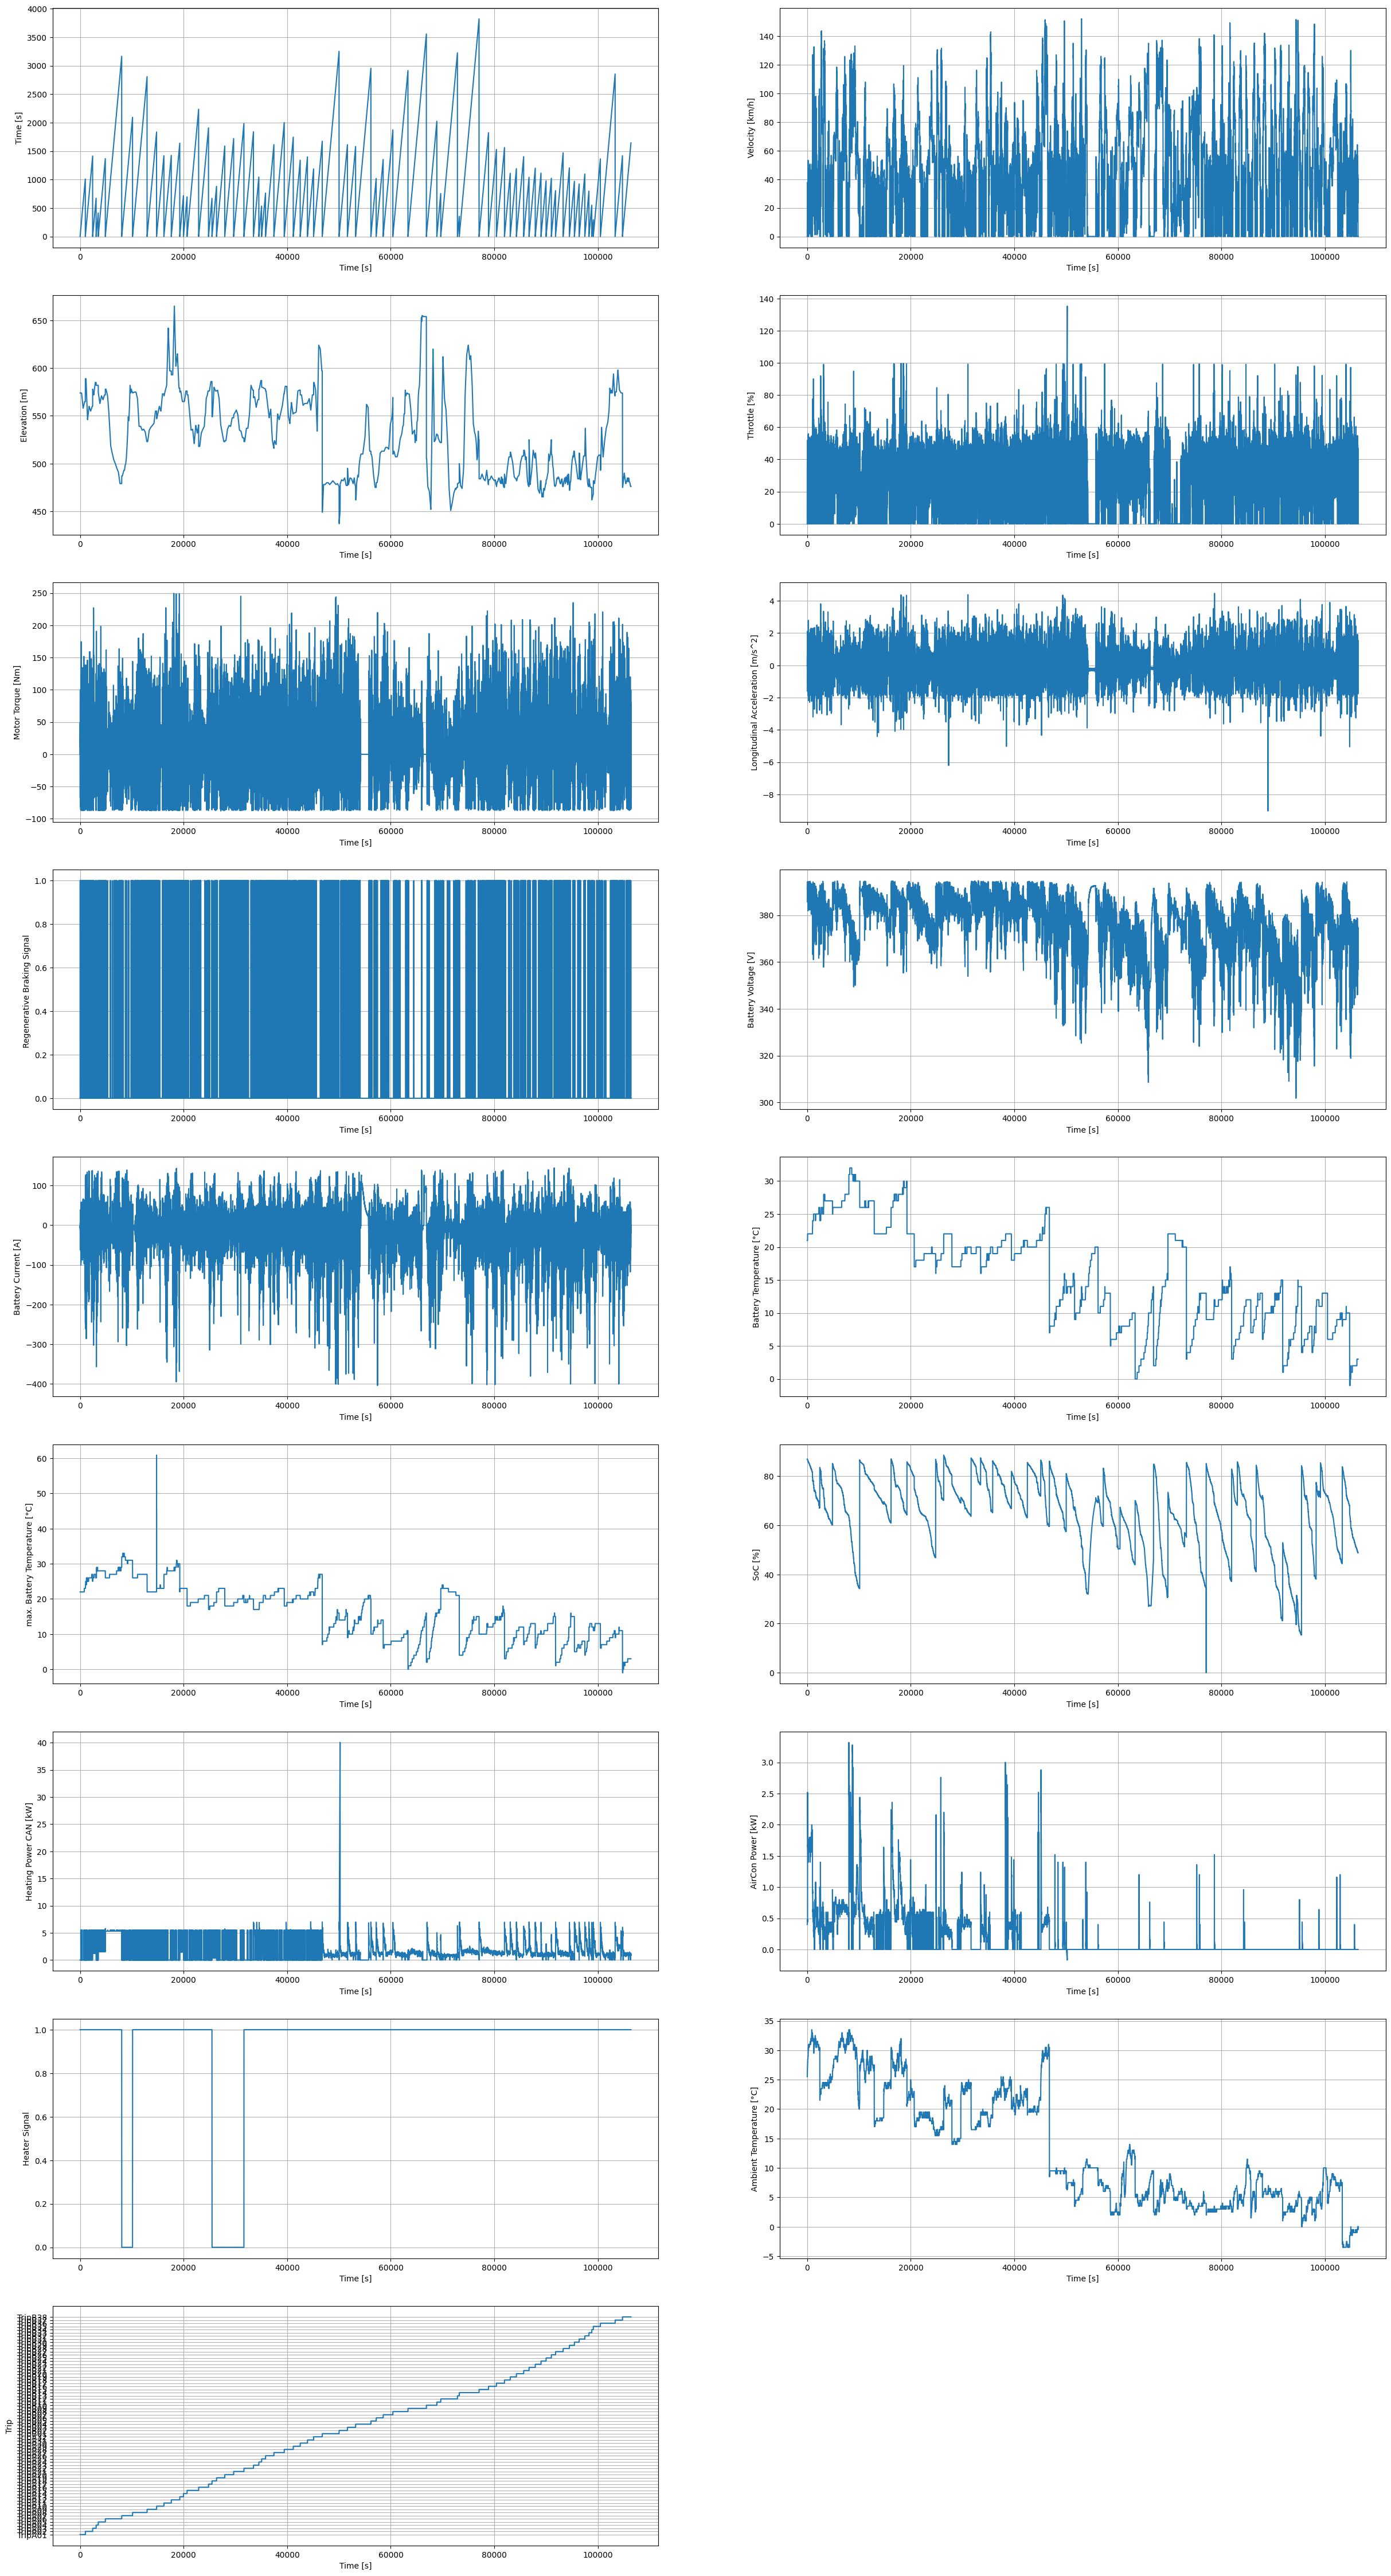

In [83]:
plot_df_subplots(all_trips, nrows=10, ncols=2, figsize=(30,64))

In [84]:
all_trips = all_trips.drop(columns=['Trip'], axis=1)
all_trips.columns

Index(['Time [s]', 'Velocity [km/h]', 'Elevation [m]', 'Throttle [%]',
       'Motor Torque [Nm]', 'Longitudinal Acceleration [m/s^2]',
       'Regenerative Braking Signal ', 'Battery Voltage [V]',
       'Battery Current [A]', 'Battery Temperature [°C]',
       'max. Battery Temperature [°C]', 'SoC [%]', 'Heating Power CAN [kW]',
       'AirCon Power [kW]', 'Heater Signal', 'Ambient Temperature [°C]'],
      dtype='object')

<Axes: >

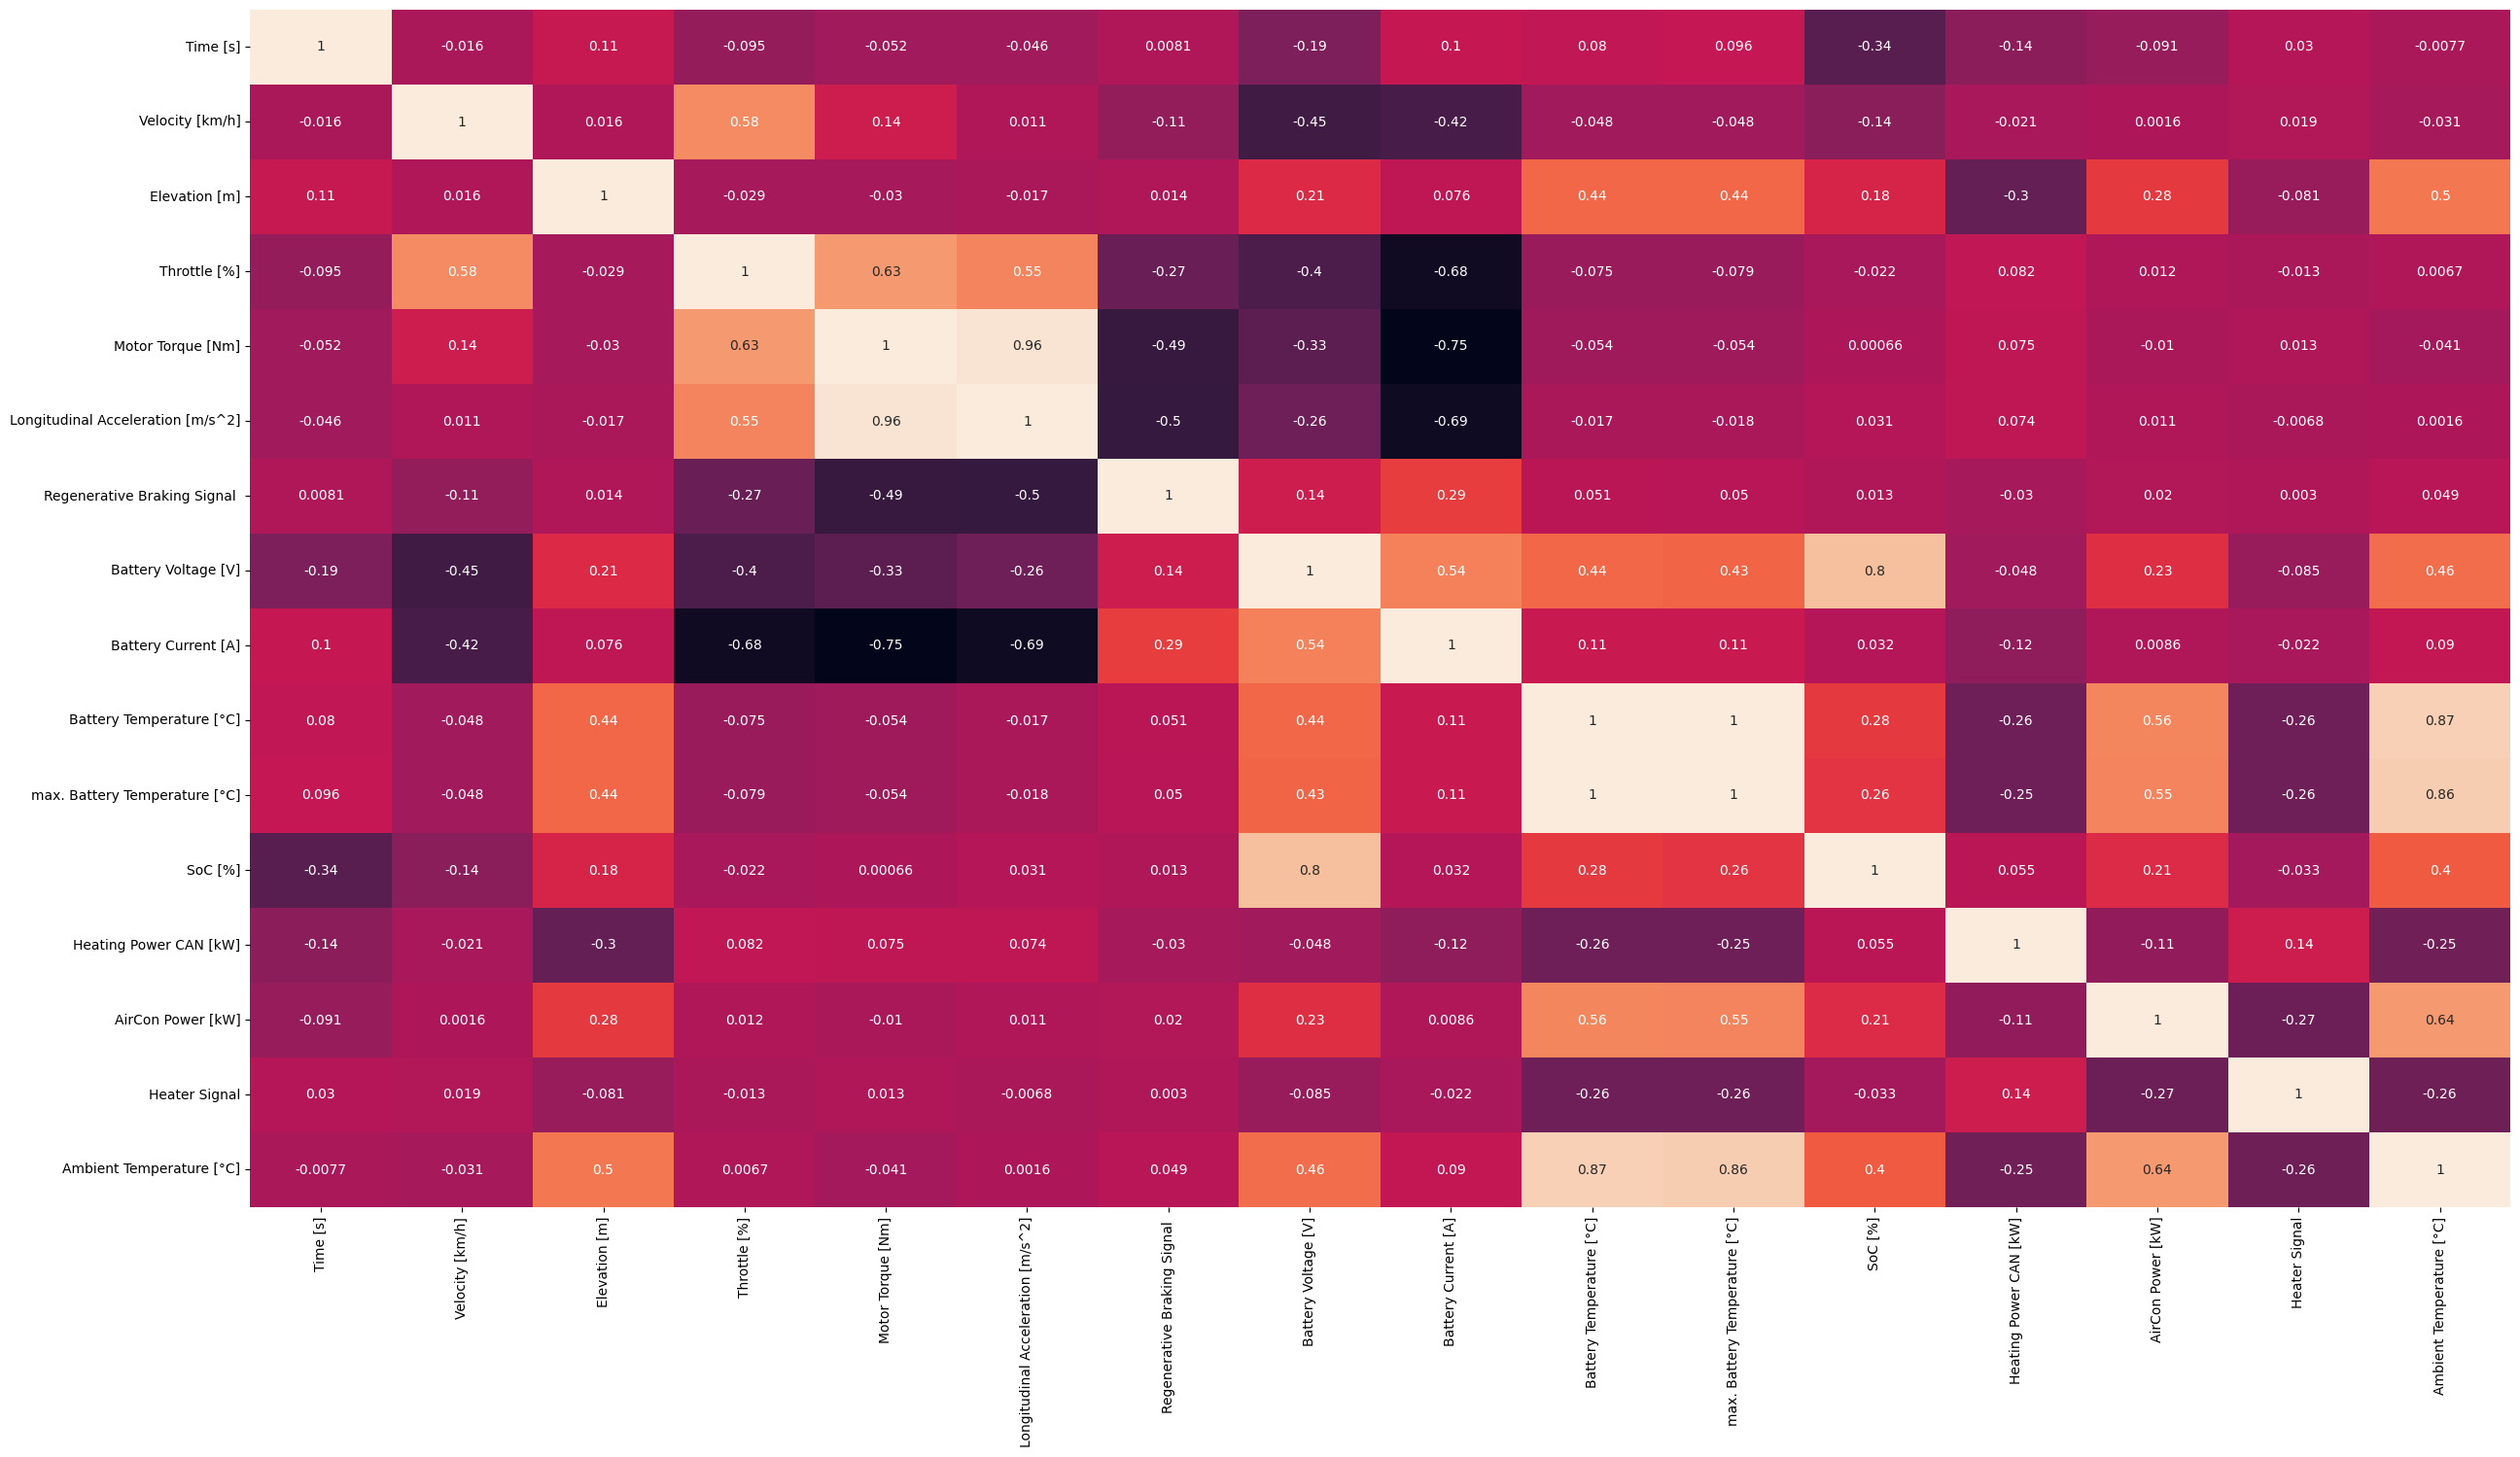

In [85]:
plt.figure(figsize=(30,16))
sns.heatmap(all_trips.corr(), annot=True, cbar=False)

# Modeling

### Train Test split

In [86]:
all_trips.columns

Index(['Time [s]', 'Velocity [km/h]', 'Elevation [m]', 'Throttle [%]',
       'Motor Torque [Nm]', 'Longitudinal Acceleration [m/s^2]',
       'Regenerative Braking Signal ', 'Battery Voltage [V]',
       'Battery Current [A]', 'Battery Temperature [°C]',
       'max. Battery Temperature [°C]', 'SoC [%]', 'Heating Power CAN [kW]',
       'AirCon Power [kW]', 'Heater Signal', 'Ambient Temperature [°C]'],
      dtype='object')

In [87]:
# all_trips.set_index("Time [s]", inplace=False)

In [100]:
# Identify predictors and outcome of the regression model.
predictors = ['Velocity [km/h]', 'Elevation [m]', 'Throttle [%]',
       'Motor Torque [Nm]', 'Longitudinal Acceleration [m/s^2]',
       'Regenerative Braking Signal ', 'Battery Voltage [V]',
       'Battery Current [A]', 'Battery Temperature [°C]',
       'max. Battery Temperature [°C]','Heating Power CAN [kW]',
       'AirCon Power [kW]', 'Heater Signal', 'Ambient Temperature [°C]']
outcome =  'SoC [%]'

# Identify X and y variables for regression and partition data
# using 60% of records for training and 40% for validation 
# (test_size=0.4). 
X = all_trips[predictors]
y = all_trips[outcome]

split = int(len(X) * 0.7)

train_X = X.values[:split]
test_X = X.values[split:]
train_y = y.values[:split]
test_y = y.values[split:]

train_X.shape, train_y.shape, test_X.shape, test_y.shape

((744800, 14), (744800,), (319200, 14), (319200,))

## Simple Linear Regression

In [89]:
# Create multiple linear regression model using X and y
# and LinearRegression() function from sklearn (skikit-learn) 
# library.
trip_lm = LinearRegression()
trip_lm.fit(train_X, train_y)

# Display intercept and regression coefficients. Round
# them to 2 decimals.
print('Regression Model for All Trips Training Set')
print()
print('Intercept: ', np.round(trip_lm.intercept_, 2))
print(pd.DataFrame({'Predictor': X.columns, 'Coefficient': np.round(trip_lm.coef_, 2)}))


Regression Model for All Trips Training Set

Intercept:  -519.93
                            Predictor  Coefficient
0                     Velocity [km/h]         0.07
1                       Elevation [m]         0.01
2                        Throttle [%]        -0.01
3                   Motor Torque [Nm]        -0.05
4   Longitudinal Acceleration [m/s^2]         0.83
5        Regenerative Braking Signal          0.91
6                 Battery Voltage [V]         1.54
7                 Battery Current [A]        -0.21
8            Battery Temperature [°C]         0.52
9       max. Battery Temperature [°C]        -1.27
10             Heating Power CAN [kW]         0.15
11                  AirCon Power [kW]         0.78
12                      Heater Signal         0.78
13           Ambient Temperature [°C]         0.30


In [97]:
valid_y.shape

(319200,)

In [96]:
y_pred_lr.shape

(319200,)

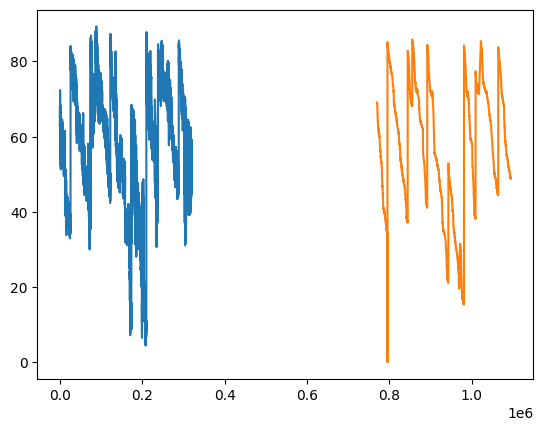

In [93]:
regressor = LinearRegression()
regressor.fit(train_X, train_y)
y_pred_lr = regressor.predict(valid_X)

plt.plot(y_pred_lr)
plt.plot(valid_y)

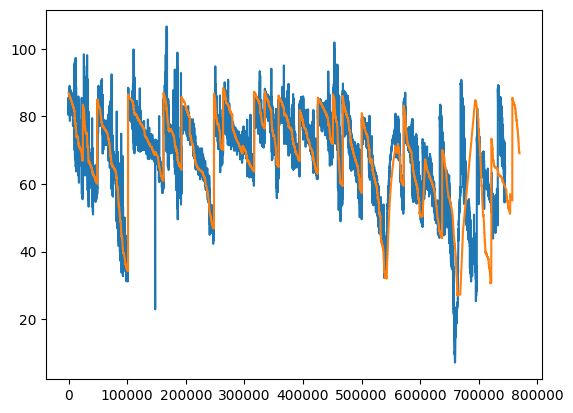

In [95]:
train_pred = regressor.predict(train_X)
plt.plot(train_pred)
plt.plot(train_y)

In [58]:
# Use predict() to score (make) predictions for validation set.
trip_lm_pred = trip_lm.predict(valid_X)

# Develop and display data frame with actual values of Price,
# scoring (predicted) results, and residuals.
# Use round() function to round vlaues in data frame to 
# 2 decimals. 
print('Actual, Prediction, and Residual Prices for Validation Set')
result = round(pd.DataFrame({'Actual': valid_y,'Predicted': trip_lm_pred, 
                       'Residual': valid_y - trip_lm_pred}), 2)
print(result.head(10))

Actual, Prediction, and Residual Prices for Validation Set
        Actual  Predicted  Residual
769537    69.1      65.31      3.79
769538    69.1      65.47      3.63
769539    69.1      65.44      3.66
769540    69.1      65.52      3.58
769541    69.1      65.73      3.37
769542    69.1      65.88      3.22
769543    69.1      65.98      3.12
769544    69.1      66.16      2.94
769545    69.1      66.27      2.83
769546    69.1      66.40      2.70


In [49]:
# Use predict() function to make predictions for
# training set.
pred_y = trip_lm.predict(train_X)

# Create prediction performance measures for training set.
r2 = round(r2_score(train_y, pred_y),3)
adj_r2 = round(adjusted_r2_score(train_y, pred_y, trip_lm),3)
aic = round(AIC_score(train_y, pred_y, trip_lm),2)
bic = round(BIC_score(train_y, pred_y, trip_lm),2)

# Display prediction performance measures for training set.
print('Prediction Performance Measures for Training Set')
print('r2 : ', r2)
print('Adjusted r2 : ', adj_r2)
print('AIC : ', aic)
print('BIC : ', bic)
print() 

# Create prediction performance measures for validation set.
r2 = round(r2_score(valid_y, trip_lm_pred),3)
adj_r2 = round(adjusted_r2_score(valid_y, trip_lm_pred, trip_lm),3)
aic = round(AIC_score(valid_y, trip_lm_pred, trip_lm),2)
bic = round(BIC_score(valid_y, trip_lm_pred, trip_lm),2)

# Display prediction performance measures for validation set.
print('Prediction Performance Measures for Validation Set')
print('r2 : ', r2)
print('adjusted r2 : ', adj_r2)
print('AIC : ', aic)
print('BIC : ', bic)

Prediction Performance Measures for Training Set
r2 :  0.905
Adjusted r2 :  0.905
AIC :  4185733.59
BIC :  4185917.92

Prediction Performance Measures for Validation Set
r2 :  0.931
adjusted r2 :  0.931
AIC :  1852524.28
BIC :  1852695.05


In [50]:
# Display common accuracy measures for training set.
print('Accuracy Measures for Training Set - All Variables')
regressionSummary(train_y, pred_y)
print()

# Display common accuracy measures for validation set.
print('Accuracy Measures for Validation Set - All Variables')
regressionSummary(valid_y, trip_lm_pred)

Accuracy Measures for Training Set - All Variables

Regression statistics

                      Mean Error (ME) : -0.0000
       Root Mean Squared Error (RMSE) : 4.0189
            Mean Absolute Error (MAE) : 2.9239
          Mean Percentage Error (MPE) : -0.3950
Mean Absolute Percentage Error (MAPE) : 4.8391

Accuracy Measures for Validation Set - All Variables

Regression statistics

               Mean Error (ME) : 0.0641
Root Mean Squared Error (RMSE) : 4.4054
     Mean Absolute Error (MAE) : 3.2962


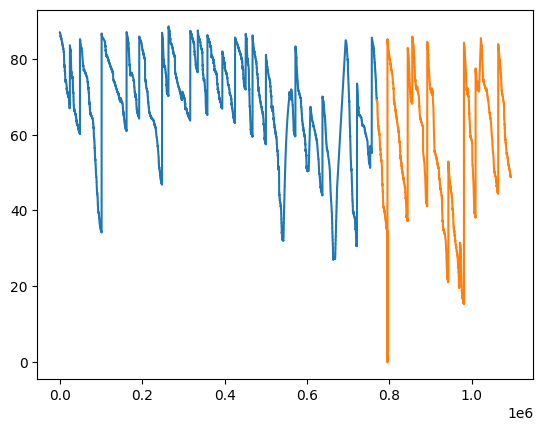

In [62]:
plt.plot(train_y)
plt.plot(valid_y)

In [64]:
pred_y = trip_lm.predict(valid_X)

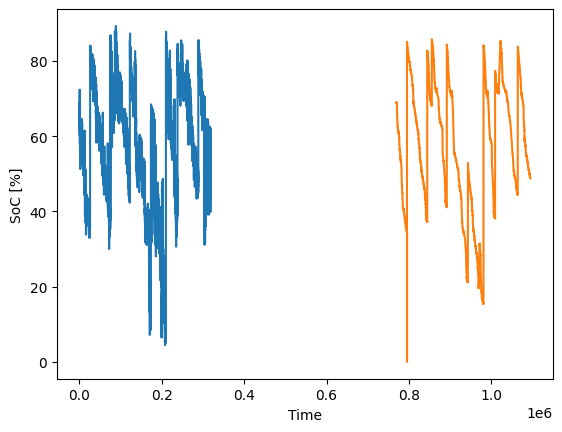

In [66]:
plt.plot(trip_lm_pred)
plt.plot(valid_y)
plt.xlabel('Time')
plt.ylabel('SoC [%]')
plt.show()

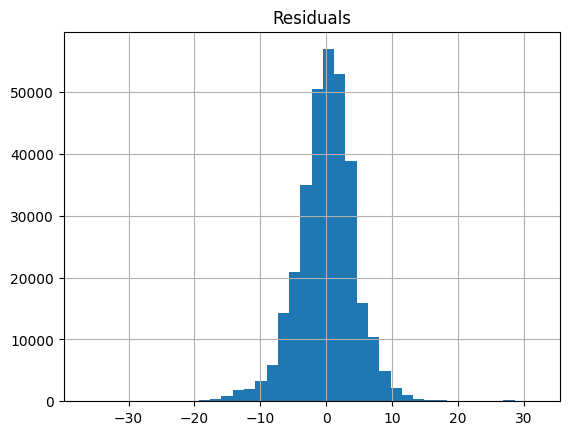

In [41]:
# Identify validation residuals of the regression model
# to check if they have approximately normal distribution.
trip_lm_pred = trip_lm.predict(valid_X)
all_residuals = valid_y - trip_lm_pred

# Develop data frame for the histogram using hist()
# function.
ax = pd.DataFrame({'Residuals': all_residuals}).hist(bins=40)

# Show histogram plot. 
# plt.tight_layout()
plt.show()

## Linear Regression 2

In [101]:
# 1. Create a model
regressor = LinearRegression()
# 2. Fit the model
regressor.fit(train_X, train_y)
# 3. Make predicitons with the model
y_pred_lr = regressor.predict(test_X)

In [106]:
print('Regression Model for All Trips Training Set')
print()
print('Intercept: ', np.round(regressor.intercept_, 2))
print(pd.DataFrame({'Predictor': X.columns, 'Coefficient': np.round(regressor.coef_, 2)}))

Regression Model for All Trips Training Set

Intercept:  -519.93
                            Predictor  Coefficient
0                     Velocity [km/h]         0.07
1                       Elevation [m]         0.01
2                        Throttle [%]        -0.01
3                   Motor Torque [Nm]        -0.05
4   Longitudinal Acceleration [m/s^2]         0.83
5        Regenerative Braking Signal          0.91
6                 Battery Voltage [V]         1.54
7                 Battery Current [A]        -0.21
8            Battery Temperature [°C]         0.52
9       max. Battery Temperature [°C]        -1.27
10             Heating Power CAN [kW]         0.15
11                  AirCon Power [kW]         0.78
12                      Heater Signal         0.78
13           Ambient Temperature [°C]         0.30


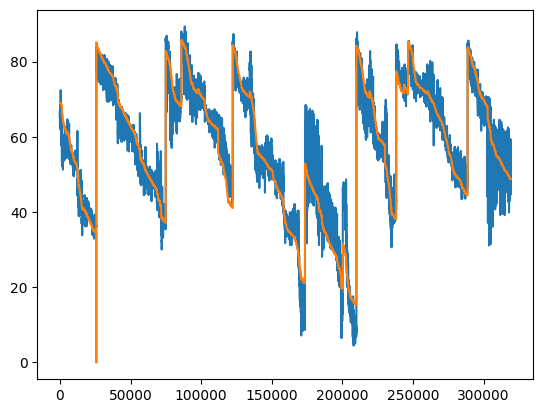

In [103]:
plt.plot(y_pred_lr)
plt.plot(test_y)

## Statsmodel Linear Regression

In [ ]:
# Apply sm.ols() function from statsmodels library
# to run a linear regression of Price on the 
# 11 predictors (including 2 dummy variables)
# in the training set.

# Create a data frame that inlcudes 11 predictors and
# outcome (Price) for training set.
train_df_sm = train_X.join(train_y)

# Display columns in train_df data frame.
train_df_sm.columns

In [ ]:
# Create predictors for the model.
predictors_sm = train_X.columns

# Develop regression model formula, where
# Price is outcome and 11 predictors. 
formula = 'train_y ~ ' + ' + '.join(predictors_sm)

# Create multiple regression model using sm.ols()
# function from statsmodels library.
trip_lm_sm = sm.ols(formula=formula, data=train_df_sm).fit()

# Display regression summary.
print(trip_lm_sm.summary()) 

# The regression coefficients are the same as for the 
# regression model using LinearRegression() function 
# from scikit-learn library.

## Forward Selection Algorithm

In [ ]:
# Define train_model() function used in Forward Selection
# algorithm with forward_selection() function. 
# The initial model is the constant model - this requires 
# special handling in train_model and score_model.
def train_model(variables):
    if len(variables) == 0:
        return None
    model = LinearRegression()
    model.fit(train_X[variables], train_y)
    return model

# Define score_model() function used in Forward Selection
# algorithm with forward_selection() function. 
def score_model(model, variables):
    if len(variables) == 0:
        return AIC_score(train_y, [train_y.mean()] * len(train_y), model, df=1)
    return AIC_score(train_y, model.predict(train_X[variables]), model)

# Use forward_selection() function to identify the
# best_model and best_variables.
best_model_fs, best_variables_fs = forward_selection(train_X.columns, 
                    train_model, score_model, verbose=True)

# Display best variables based on Forward Selection algorithm.
print()
print('Best Variables from Forward Selection Algorithm')
print(best_variables_fs)

In [ ]:
# Develop the multiple linear regression model based
# on the Forward Selection results.

# Identify predictors and outcome of the regression model.
predictors_fs = ['Battery Voltage [V]', 'Battery Current [A]', 'max. Battery Temperature [°C]', 
                 'Velocity [km/h]', 'Ambient Temperature [°C]', 'Motor Torque [Nm]', 'Elevation [m]', 
                 'AirCon Power [kW]', 'Heating Power CAN [kW]', 'Battery Temperature [°C]', 'Heater Signal', 
                 'Throttle [%]', 'Regenerative Braking Signal ', 'Longitudinal Acceleration [m/s^2]']
outcome = 'SoC [%]'

# Identify X and y variables for regression and partition data
# using 60% of records for training and 40% for validation 
# (test_size=0.4). 
X = all_trips[predictors_fs]
y = all_trips[outcome]
train_X_fs, valid_X_fs, train_y_fs, valid_y_fs = \
          train_test_split(X, y, test_size=0.4, random_state=1)

# Create multiple linear regression model using X and y.
car_fs = LinearRegression()
car_fs.fit(train_X_fs, train_y_fs)

# Display intercept and regression coefficients. Round them
# to 2 decimals.
print('Regression Model for Training Set Using Forward Selection')
print()
print('Intercept ', np.round(car_fs.intercept_, 2))
print(pd.DataFrame({'Predictor': X.columns,
            'Coefficient': np.round(car_fs.coef_, 2)}))

In [ ]:
# Use predict() to score predictions for validation set.
car_fs_pred = car_fs.predict(valid_X_fs)

# Develop and display data frame with actual values of Price,
# scoring (predicted) results, and residuals.
# Use round() function to round vlaues in data frame to 
# 2 decimals. 
result = round(pd.DataFrame({'Actual': valid_y_fs,'Predicted': car_fs_pred, 
                       'Residual': valid_y_fs - car_fs_pred}), 2)
print()
print('Predictions for Validation Set Using Forward Selection')
print(result.head(10))

# Display common accuracy measures for validation set.
print()
print('Accuracy Measures for Validation Set Using Forward Selection')
regressionSummary(valid_y_fs, car_fs_pred)

In [ ]:
# Initialize the XGBoost regressor
model = xgb.XGBRegressor(objective ='reg:squarederror', seed=42)

# Train the model
model.fit(train_X, train_y)

## Neural Network - TensorFlow

In [117]:
# 1. Create a model
regressor1 = Sequential([
    layers.Dense(14),
    layers.Dense(7),
    layers.Dense(1),
])

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
# 2. Compile a model
regressor1.compile(optimizer=optimizers.Adam(learning_rate=0.001),
                  loss=losses.mae,
                  metrics=["mae"])


In [118]:

# 3. Fit a model
regressor1.fit(train_X, train_y, epochs=20, callbacks=[callback], verbose=True)

Epoch 1/20
23275/23275 [==============================] - 13s 534us/step - loss: 8.4355 - mae: 8.4355
Epoch 2/20
23275/23275 [==============================] - 12s 535us/step - loss: 7.7916 - mae: 7.7916
Epoch 3/20
23275/23275 [==============================] - 13s 539us/step - loss: 7.5184 - mae: 7.5184
Epoch 4/20
23275/23275 [==============================] - 12s 530us/step - loss: 7.2253 - mae: 7.2253
Epoch 5/20
23275/23275 [==============================] - 12s 533us/step - loss: 7.0249 - mae: 7.0249
Epoch 6/20
23275/23275 [==============================] - 12s 531us/step - loss: 6.7861 - mae: 6.7861
Epoch 7/20
23275/23275 [==============================] - 12s 532us/step - loss: 6.4692 - mae: 6.4692
Epoch 8/20
23275/23275 [==============================] - 12s 533us/step - loss: 6.0906 - mae: 6.0906
Epoch 9/20
23275/23275 [==============================] - 12s 528us/step - loss: 5.6155 - mae: 5.6155
Epoch 10/20
23275/23275 [==============================] - 12s 531us/step - loss: 

In [119]:
# 4. Validate the model
y_pred_nn = regressor.predict(test_X)

Text(0, 0.5, 'SoC [%]')

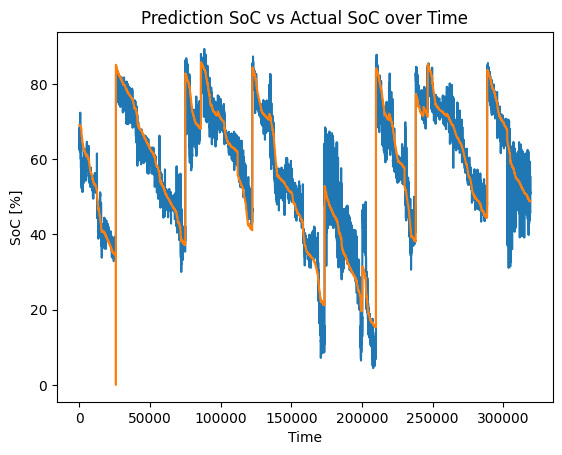

In [122]:
plt.plot(y_pred_nn, label='Prediction')
plt.plot(test_y, label='Actual')
plt.title("Prediction SoC vs Actual SoC over Time")
plt.xlabel('Time')
plt.ylabel('SoC [%]')

In [ ]:
# Assuming X is your features and y is your target variable
# Normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler.fit_transform(X)
X_scaled.shape

In [ ]:
# Reshape input to be [samples, time steps, features]
X_reshaped = np.reshape(X_scaled, (X_scaled.shape[0], 1, X_scaled.shape[1]))
X_reshaped.shape

In [ ]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y, test_size=0.2)

In [ ]:
# Create the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(1, X_train.shape[2])))
model.add(LSTM(units=50))
model.add(Dense(1))

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
# Fit the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), verbose=2)

# Evaluate the model
predictions = model.predict(X_test)

In [ ]:
# Assuming 'scaler' is your MinMaxScaler instance and you've scaled the target variable
actuals = scaler.inverse_transform(y_test.reshape(-1, 1))
predicted = scaler.inverse_transform(predictions)

In [ ]:
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(10, 6))
# plt.plot(actuals, label='Actual')
# plt.plot(predicted, label='Predicted')
plt.plot(predictions, label='Predicted')
plt.plot(y_test)
plt.title('LSTM Model Predictions vs Actual')
plt.xlabel('Time Steps')
plt.ylabel('Battery Level')
plt.legend()
plt.show()


In [ ]:
def regression_matrics(y_test, y_pred):
    # calculate errors
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae = mean_absolute_error(y_test, y_pred)
    # report error
    print(f'Mean Squared Error: {mse}')
    print(f'Root Mean Square Error: {rmse}')
    print(f'Mean Absolute Error: {mae}')


def plot_comparison(y_test, y_pred, xlabel, ylabel, dark_mode=False, figsize=(30, 6)):
    if dark_mode:
        plt.figure(figsize=figsize, facecolor='black')
        ax = plt.axes()
        ax.set_facecolor("black")
        ax.spines['bottom'].set_color('gray')
        ax.spines['top'].set_color('gray')
        ax.spines['right'].set_color('gray')
        ax.spines['left'].set_color('gray')
        ax.tick_params(colors='white', which='both')
        plt.plot(y_pred, color="yellow")
        plt.plot(y_test, color="white")
        plt.legend(['Predicted', 'Measured'])
        plt.xlabel(xlabel, color='white')
        plt.ylabel(ylabel, color='white')
    else:
        plt.figure(figsize=figsize)
        plt.plot(y_pred)
        plt.plot(y_test)        
        plt.legend(['Predicted', 'Measured'])
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
    plt.grid(True)

In [32]:
# fix python path if working locally
# from utils import fix_pythonpath_if_working_locally

# fix_pythonpath_if_working_locally()

import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.utils.timeseries_generation import (
    gaussian_timeseries,
    linear_timeseries,
    sine_timeseries,
)
from darts.models import (
    RNNModel,
    TCNModel,
    TransformerModel,
    NBEATSModel,
    BlockRNNModel,
    VARIMA,
)
from darts.metrics import mape, smape, mae, rmse
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.datasets import AirPassengersDataset, MonthlyMilkDataset, ElectricityDataset

import logging

logging.disable(logging.CRITICAL)

import warnings

warnings.filterwarnings("ignore")

%matplotlib inline

# for reproducibility
torch.manual_seed(1)
np.random.seed(1)

In [2]:
df1 = pd.read_csv('archive/TripA01.csv', sep=';', encoding="unicode_escape")
df2 = pd.read_csv('archive/TripA02.csv', sep=';', encoding="unicode_escape")
# df3 = pd.read_csv('archive/TripA03.csv', sep=';', encoding="unicode_escape")
# df4 = pd.read_csv('archive/TripA04.csv', sep=';', encoding="unicode_escape")

In [3]:
df1.head(2)

,Time [s],Velocity [km/h],Elevation [m],Throttle [%],Motor Torque [Nm],Longitudinal Acceleration [m/s^2],Regenerative Braking Signal,Battery Voltage [V],Battery Current [A],Battery Temperature [°C],...,AirCon Power [kW],Heater Signal,Heater Voltage [V],Heater Current [A],Ambient Temperature [°C],Coolant Temperature Heatercore [°C],Requested Coolant Temperature [°C],Coolant Temperature Inlet [°C],Heat Exchanger Temperature [°C],Cabin Temperature Sensor [°C]
0,0.0,0.0,574.0,0.0,0.0,-0.03,0.0,391.4,-2.20,21.0,...,0.4,1,0,0,25.5,0,0,0,30.5,24.5
1,0.1,0.0,574.0,0.0,0.0,0.00,0.0,391.4,-2.21,21.0,...,0.4,1,0,0,25.5,0,0,0,30.5,24.5


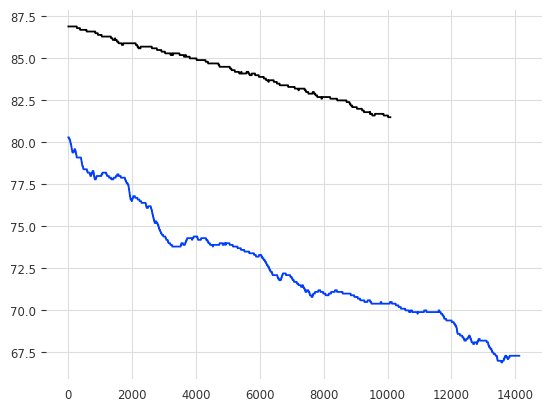

In [4]:
plt.plot(df1['SoC [%]'])
plt.plot(df2['SoC [%]'])

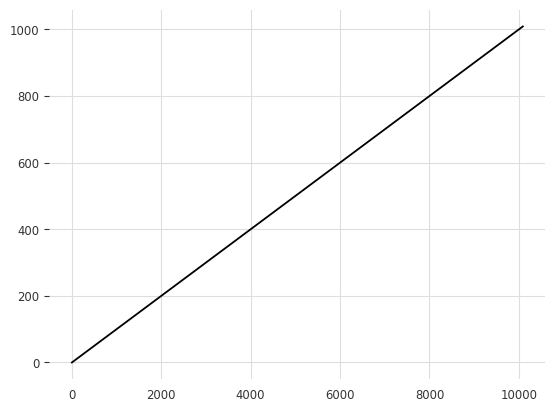

In [5]:
plt.plot(df1["Time [s]"])

In [9]:
# df1["Time [s]"] = pd.to_datetime(df1["Time [s]"], unit='s')
df1.set_index("Time [s]", inplace=False)
df2.set_index("Time [s]", inplace=False)
df1

,Time [s],Velocity [km/h],Elevation [m],Throttle [%],Motor Torque [Nm],Longitudinal Acceleration [m/s^2],Regenerative Braking Signal,Battery Voltage [V],Battery Current [A],Battery Temperature [°C],...,AirCon Power [kW],Heater Signal,Heater Voltage [V],Heater Current [A],Ambient Temperature [°C],Coolant Temperature Heatercore [°C],Requested Coolant Temperature [°C],Coolant Temperature Inlet [°C],Heat Exchanger Temperature [°C],Cabin Temperature Sensor [°C]
2020-01-01 00:00:00,0.0,0.00,574.0,0.00,0.0,-0.03,0.0,391.40,-2.20,21.0,...,0.40,1,0,0,25.5,0,0,0,30.5,24.50
2020-01-01 00:00:01,0.1,0.00,574.0,0.00,0.0,0.00,0.0,391.40,-2.21,21.0,...,0.40,1,0,0,25.5,0,0,0,30.5,24.50
2020-01-01 00:00:02,0.2,0.00,574.0,0.00,0.0,-0.01,0.0,391.40,-2.26,21.0,...,0.40,1,0,0,25.5,0,0,0,30.5,24.50
2020-01-01 00:00:03,0.3,0.00,574.0,0.00,0.0,-0.03,0.0,391.40,-2.30,21.0,...,0.40,1,0,0,25.5,0,0,0,30.5,24.50
2020-01-01 00:00:04,0.4,0.00,574.0,0.00,0.0,-0.03,0.0,391.40,-2.30,21.0,...,0.40,1,0,0,25.5,0,0,0,30.5,24.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-01 02:48:05,1008.5,20.71,565.0,25.06,-9.4,-0.28,0.0,387.91,-3.12,22.0,...,1.92,1,0,0,33.0,0,0,0,5.0,22.67
2020-01-01 02:48:06,1008.6,20.60,565.0,23.57,-8.9,-0.24,0.0,387.96,-2.37,22.0,...,1.92,1,0,0,33.0,0,0,0,5.0,22.67
2020-01-01 02:48:07,1008.7,20.44,565.0,22.55,-12.4,-0.31,0.0,388.01,-1.62,22.0,...,1.92,1,0,0,33.0,0,0,0,5.0,22.67
2020-01-01 02:48:08,1008.8,20.30,565.0,22.55,-15.2,-0.40,0.0,388.06,-0.92,22.0,...,1.92,1,0,0,33.0,0,0,0,5.0,22.67


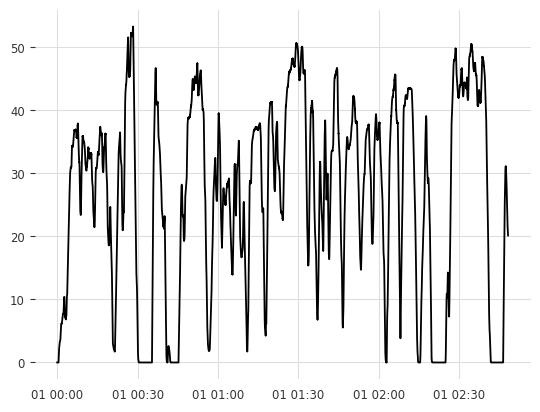

In [10]:
plt.plot(df1['Velocity [km/h]'])

In [11]:
start_time = '2020-01-01'  # Example start date
df1.index = pd.date_range(start=start_time, periods=len(df1), freq='S')
df2.index = pd.date_range(start=start_time, periods=len(df2), freq='S')
df1.head()

,Time [s],Velocity [km/h],Elevation [m],Throttle [%],Motor Torque [Nm],Longitudinal Acceleration [m/s^2],Regenerative Braking Signal,Battery Voltage [V],Battery Current [A],Battery Temperature [°C],...,AirCon Power [kW],Heater Signal,Heater Voltage [V],Heater Current [A],Ambient Temperature [°C],Coolant Temperature Heatercore [°C],Requested Coolant Temperature [°C],Coolant Temperature Inlet [°C],Heat Exchanger Temperature [°C],Cabin Temperature Sensor [°C]
2020-01-01 00:00:00,0.0,0.0,574.0,0.0,0.0,-0.03,0.0,391.4,-2.20,21.0,...,0.4,1,0,0,25.5,0,0,0,30.5,24.5
2020-01-01 00:00:01,0.1,0.0,574.0,0.0,0.0,0.00,0.0,391.4,-2.21,21.0,...,0.4,1,0,0,25.5,0,0,0,30.5,24.5
2020-01-01 00:00:02,0.2,0.0,574.0,0.0,0.0,-0.01,0.0,391.4,-2.26,21.0,...,0.4,1,0,0,25.5,0,0,0,30.5,24.5
2020-01-01 00:00:03,0.3,0.0,574.0,0.0,0.0,-0.03,0.0,391.4,-2.30,21.0,...,0.4,1,0,0,25.5,0,0,0,30.5,24.5
2020-01-01 00:00:04,0.4,0.0,574.0,0.0,0.0,-0.03,0.0,391.4,-2.30,21.0,...,0.4,1,0,0,25.5,0,0,0,30.5,24.5


In [12]:
df1.index.freq = 'S'
df2.index.freq = 'S'

In [13]:
velo_ts1 = TimeSeries.from_dataframe(df1, value_cols='Velocity [km/h]')
accel_ts1 = TimeSeries.from_dataframe(df1, value_cols='Longitudinal Acceleration [m/s^2]')
soc_ts1 = TimeSeries.from_dataframe(df1, value_cols='SoC [%]')


velo_ts2 = TimeSeries.from_dataframe(df2, value_cols='Velocity [km/h]')
accel_ts2 = TimeSeries.from_dataframe(df2, value_cols='Longitudinal Acceleration [m/s^2]')
soc_ts2 = TimeSeries.from_dataframe(df2, value_cols='SoC [%]')


velo_ts1

<TimeSeries (DataArray) (time: 10090, component: 1, sample: 1)>
array([[[ 0.  ]],

       [[ 0.  ]],

       [[ 0.  ]],

       ...,

       [[20.44]],

       [[20.3 ]],

       [[20.14]]])
Coordinates:
  * time       (time) datetime64[ns] 2020-01-01 ... 2020-01-01T02:48:09
  * component  (component) object 'Velocity [km/h]'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [14]:
batt_covar1 = velo_ts1.stack(accel_ts1)
batt_covar2 = velo_ts2.stack(accel_ts2)

# batt_covar.plot()

In [15]:
scaler = Scaler()

<Axes: xlabel='time'>

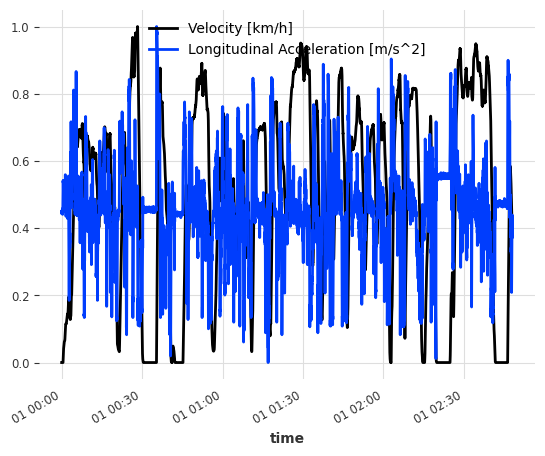

In [17]:
batt_covar1 = scaler.fit_transform(batt_covar1)
batt_covar2 = scaler.fit_transform(batt_covar2)
batt_covar1.plot()

In [18]:
soc_ts1 = scaler.fit_transform(soc_ts1)
soc_ts2 = scaler.fit_transform(soc_ts2)

In [19]:
soc_train1, soc_valid1 = soc_ts1[:-4000], soc_ts1[-4000:]
batt_covar_train1, batt_covar_valid1 = batt_covar1[:-4000], batt_covar1[-4000:]

soc_train2, soc_valid2 = soc_ts2[:-6000], soc_ts2[-6000:]
batt_covar_train2, batt_covar_valid2 = batt_covar2[:-6000], batt_covar2[-6000:]

In [20]:
model_pastcov = BlockRNNModel(
    model="LSTM",
    input_chunk_length=600,
    output_chunk_length=60,
    n_epochs=10,
    random_state=0,
)

In [21]:
model_pastcov.fit(
    series=[soc_train1, soc_train2],
    past_covariates=[batt_covar_train1, batt_covar_train2],
    verbose=True,
);

Training: |                                                                                      | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

RMSE = 0.14%


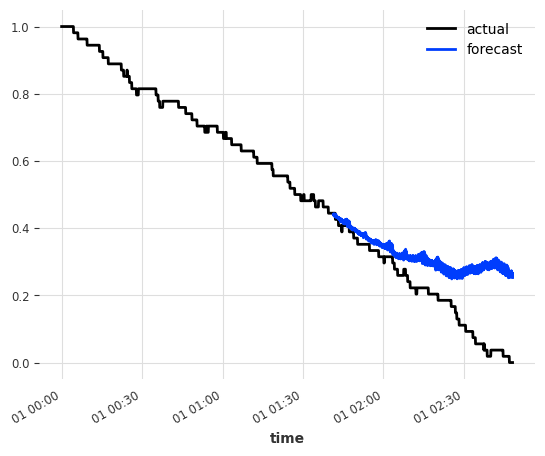

In [33]:
pred_cov = model_pastcov.predict(n=4000, series=soc_train1, past_covariates=batt_covar1)

soc_ts1.plot(label="actual")
pred_cov.plot(label="forecast")
plt.legend()
print("RMSE = {:.2f}%".format(rmse(soc_ts1, pred_cov)))